In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
folder_path = "E:\\Formation Data Scientist\\Projet_5\\ressources\\archive\\"
customers = pd.read_csv(folder_path + "olist_customers_dataset.csv")
order_items = pd.read_csv(folder_path + "olist_order_items_dataset.csv")
orders = pd.read_csv(folder_path + "olist_orders_dataset.csv")
geolocation = pd.read_csv(folder_path + 'olist_geolocation_dataset.csv')
order_payments = pd.read_csv(folder_path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(folder_path + 'olist_order_reviews_dataset.csv')
products = pd.read_csv(folder_path + 'olist_products_dataset.csv')
sellers = pd.read_csv(folder_path + 'olist_sellers_dataset.csv')
translation = pd.read_csv(folder_path + 'product_category_name_translation.csv')


In [4]:
print(customers.shape)
print(order_items.shape)
print(orders.shape)
print(geolocation.shape)
print(order_payments.shape)
print(order_reviews.shape)
print(products.shape)
print(sellers.shape)
print(translation.shape)

(99441, 5)
(112650, 7)
(99441, 8)
(1000163, 5)
(103886, 5)
(99224, 7)
(32951, 9)
(3095, 4)
(71, 2)


In [5]:
customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [6]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [7]:
geolocation.head(1)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP


- Merge des catégories de produits et leur nom en Anglais

In [8]:
fus_cats = pd.merge(products,translation,indicator=True)

In [9]:
fus_cats.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,_merge
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,both


- Drop des colonnes non essentielles

In [10]:
fus_cats.drop(columns=['product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm',
              'product_width_cm','_merge'],inplace=True)

In [11]:
fus_cats.shape

(32328, 3)

In [12]:
fus_cats.isna().sum()

product_id                       0
product_category_name            0
product_category_name_english    0
dtype: int64

- Fusion de la trame des **clients** et de la trame des **commandes**

In [13]:
fus1 = pd.merge(customers,orders, indicator=True)

In [14]:
fus1.shape

(99441, 13)

In [15]:
fus1.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,_merge
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,both


In [16]:
fus1 = fus1.drop(columns='_merge')

- Fusion de la trame des **clients** et **commandes** avec la trame **paiements**

In [17]:
fus2 = pd.merge(fus1,order_payments, indicator=True)

In [18]:
fus2

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,_merge
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,credit_card,2,146.87,both
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,credit_card,8,335.48,both
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,credit_card,7,157.73,both
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,credit_card,1,173.30,both
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,credit_card,8,252.25,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103881,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25 00:00:00,1,credit_card,6,88.78,both
103882,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20 00:00:00,1,credit_card,3,129.06,both
103883,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02 00:00:00,1,credit_card,5,56.04,both
103884,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05 00:00:00,1,credit_card,2,711.07,both


In [19]:
fus2 = fus2.drop(columns='_merge')

- Fusion de la trame des **produits** avec celle des **catégories** de produits

In [20]:
fus3 = pd.merge(order_items,fus_cats)

In [21]:
fus4 = pd.merge(fus3,fus2)

In [22]:
fus4.isna().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name               0
product_category_name_english       0
customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date     1205
order_delivered_customer_date    2495
order_estimated_delivery_date       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
dtype: int64

In [23]:
fus4.dropna(axis=0,inplace=True)

In [24]:
fus4.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_id,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,cool_stuff,3ce436f183e68e07877b285a838db11a,...,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1,credit_card,2,72.19


In [25]:
fus4.shape

(113368, 24)

In [26]:
fus4.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [27]:
fus5 = pd.merge(fus4,sellers)

In [28]:
fus5.shape

(113368, 27)

In [29]:
fus5.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state'],
      dtype='object')

In [30]:
geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [31]:
#fus5 = pd.merge(fus4,geolocation,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',indicator=True)

In [32]:
fus5.shape

(113368, 27)

<AxesSubplot:>

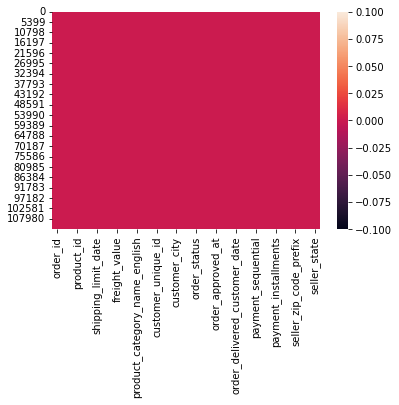

In [33]:
sns.heatmap(fus5.isna())

In [34]:
fus5.isna().sum()

order_id                         0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_category_name_english    0
customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
seller_zip_code_prefix           0
seller_city                      0
seller_state                     0
dtype: int64

In [35]:
fus5.duplicated().sum()

0

In [36]:
fus5['payment_value'].describe()

count    113368.000000
mean        172.237791
std         266.627878
min           0.000000
25%          61.000000
50%         108.140000
75%         189.370000
max       13664.080000
Name: payment_value, dtype: float64

<a name='C2'> **EDA** </a>

- **Formatage** des dates en DateTime

In [37]:
date = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
for i in date:
  fus5[i] = pd.to_datetime(fus5[i],format="%Y-%m-%d %H:%M:%S")
  
fus5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113368 entries, 0 to 113367
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113368 non-null  object        
 1   order_item_id                  113368 non-null  int64         
 2   product_id                     113368 non-null  object        
 3   seller_id                      113368 non-null  object        
 4   shipping_limit_date            113368 non-null  object        
 5   price                          113368 non-null  float64       
 6   freight_value                  113368 non-null  float64       
 7   product_category_name          113368 non-null  object        
 8   product_category_name_english  113368 non-null  object        
 9   customer_id                    113368 non-null  object        
 10  customer_unique_id             113368 non-null  object        
 11  

In [38]:
fus5['year'] = fus5['order_purchase_timestamp'].dt.year
fus5['month'] = fus5['order_purchase_timestamp'].dt.month
fus5['day'] = fus5['order_purchase_timestamp'].dt.dayofweek
fus5['day_name'] = fus5['order_purchase_timestamp'].dt.day_name()
fus5['month_name'] = fus5['order_purchase_timestamp'].dt.month_name()

In [39]:
fus5.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_id,...,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,year,month,day,day_name,month_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,cool_stuff,3ce436f183e68e07877b285a838db11a,...,2,72.19,27277,volta redonda,SP,2017,9,2,Wednesday,September


In [40]:
fus5['month_name'].unique()

array(['September', 'June', 'May', 'August', 'July', 'March', 'October',
       'April', 'November', 'February', 'December', 'January'],
      dtype=object)

- **Drop** des Null

In [41]:
drop1 = fus5.copy()
drop1 = drop1.dropna(axis=0)
drop1.shape

(113368, 32)

In [42]:
drop1.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'year', 'month', 'day', 'day_name', 'month_name'],
      dtype='object')

Nous avons besoin des colonnes qui nous donnent des informations sur la **récense**, la **fréquence** et le **montant** des transactions

Drop des features non essentiels

In [43]:
#drop2 = drop1.drop(columns=['customer_city', 'order_status','order_delivered_carrier_date','order_delivered_customer_date', 'order_estimated_delivery_date','seller_city','seller_state','shipping_limit_date'])

In [44]:
drop1.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_id,...,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,year,month,day,day_name,month_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,cool_stuff,3ce436f183e68e07877b285a838db11a,...,2,72.19,27277,volta redonda,SP,2017,9,2,Wednesday,September


In [45]:
drop1.describe()

,order_item_id,price,freight_value,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix,year,month,day
count,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000
mean,1.196854,120.177066,20.024293,35082.345071,1.089946,2.942594,172.237791,24514.457307,2017.542534,6.038468,2.744787
std,0.701322,182.793493,15.753267,29845.780275,0.682117,2.777913,266.627878,27638.693371,0.504086,3.221644,1.961454
min,1.000000,0.850000,0.000000,1003.000000,1.000000,0.000000,0.000000,1001.000000,2016.000000,1.000000,0.000000
25%,1.000000,39.900000,13.080000,11320.000000,1.000000,1.000000,61.000000,6429.000000,2017.000000,3.000000,1.000000
50%,1.000000,74.900000,16.320000,24325.000000,1.000000,2.000000,108.140000,13660.000000,2018.000000,6.000000,3.000000
75%,1.000000,133.717500,21.200000,58780.000000,1.000000,4.000000,189.370000,28495.000000,2018.000000,8.000000,4.000000
max,21.000000,6735.000000,409.680000,99980.000000,26.000000,24.000000,13664.080000,99730.000000,2018.000000,12.000000,6.000000


In [46]:
drop1.dtypes

order_id                                 object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
product_category_name                    object
product_category_name_english            object
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
payment_sequential                      

<AxesSubplot:>

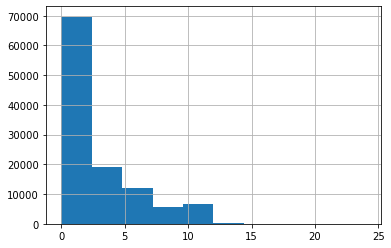

In [48]:
drop1['payment_installments'].hist(bins=10)

- Etude des clients par zone géographique

In [49]:
# Trouvons les états avec le plus de clients

customers_state = drop1.groupby(['customer_state']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
customers_state.rename(columns = {'customer_unique_id':'total'}, inplace=True)
customers_state['percentage'] = 100*(customers_state['total']/customers_state['total'].sum())
customers_state

,customer_state,total,percentage
25,SP,47819,42.180333
18,RJ,14648,12.920754
10,MG,13230,11.669960
22,RS,6283,5.542128
17,PR,5790,5.107261
23,SC,4161,3.670348
4,BA,3858,3.403077
6,DF,2389,2.107297
8,GO,2319,2.045551
7,ES,2288,2.018206


Sao Paulo est de loin l'état avec le plus de clients

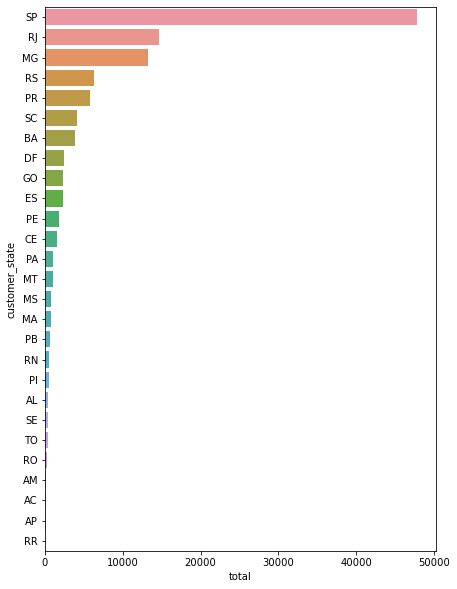

In [60]:
plt.figure(figsize=(7,10))
sns.barplot(data=customers_state,x='total',y='customer_state')
plt.show()

- Etude des clients par catégories de produits acheté

- Etude achats par date

In [52]:
purchase_year = drop1.groupby(['year']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_year.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_year['percentage'] = 100*(purchase_year['total']/purchase_year['total'].sum())
purchase_year

,year,total,percentage
2,2018,61841,54.548903
1,2017,51192,45.155599
0,2016,335,0.295498


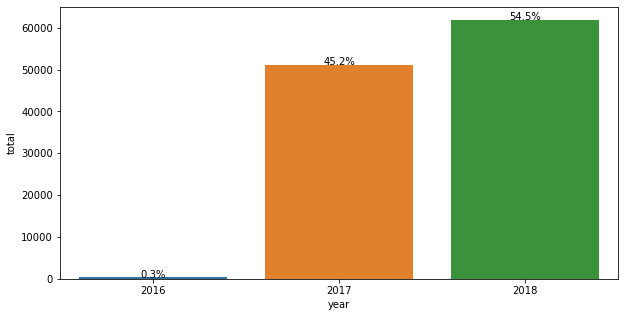

In [53]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_year,x='year',y='total')
total = purchase_year['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [54]:
purchase_month = drop1.groupby(['month_name']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_month.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_month['percentage'] = 100*(purchase_month['total'] / purchase_month['total'].sum())
purchase_month

,month_name,total,percentage
1,August,12292,10.842566
8,May,12211,10.771117
5,July,11793,10.402406
7,March,11215,9.892562
6,June,10921,9.633230
0,April,10663,9.405652
3,February,9537,8.412427
4,January,9110,8.035777
9,November,8683,7.659128
2,December,6300,5.557124


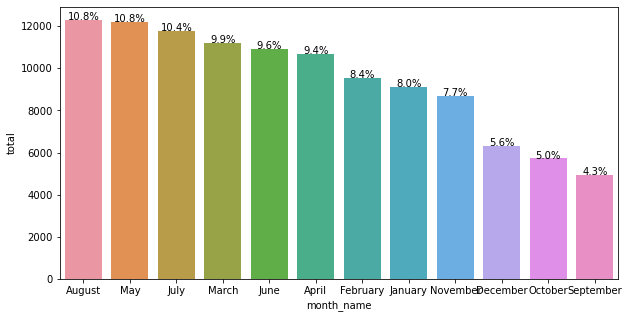

In [55]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_month,x='month_name',y='total')
total = purchase_month['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

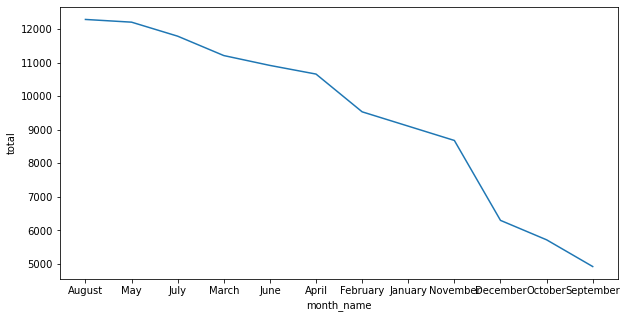

In [56]:
plt.figure(figsize=(10,5))
sns.lineplot(data=purchase_month,x='month_name',y='total')
plt.show()

In [57]:
purchase_day = drop1.groupby(['day_name']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_day.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_day

,day_name,total
1,Monday,18452
5,Tuesday,18412
6,Wednesday,17730
4,Thursday,16916
0,Friday,16179
3,Sunday,13440
2,Saturday,12239


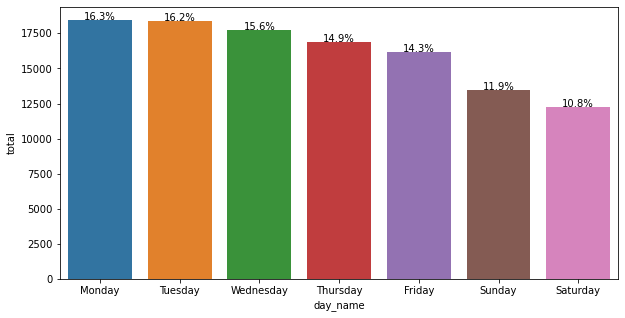

In [58]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_day,x='day_name',y='total')
total = purchase_day['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()